In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader
from src.news_providers.tradingview_provider import TradingViewProvider
from src.agents.automated_supervised_trader import AutomatedSupervisedTrader

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
coin = "ETH"

cutoff = get_current_datetime()
str(cutoff)

'2024-05-14 03:09:02.595292'

In [55]:
day_12h_history, day_history, week_history = map_async(lambda: get_12h_history(coin), lambda: get_day_history(coin), lambda: get_week_history(coin))

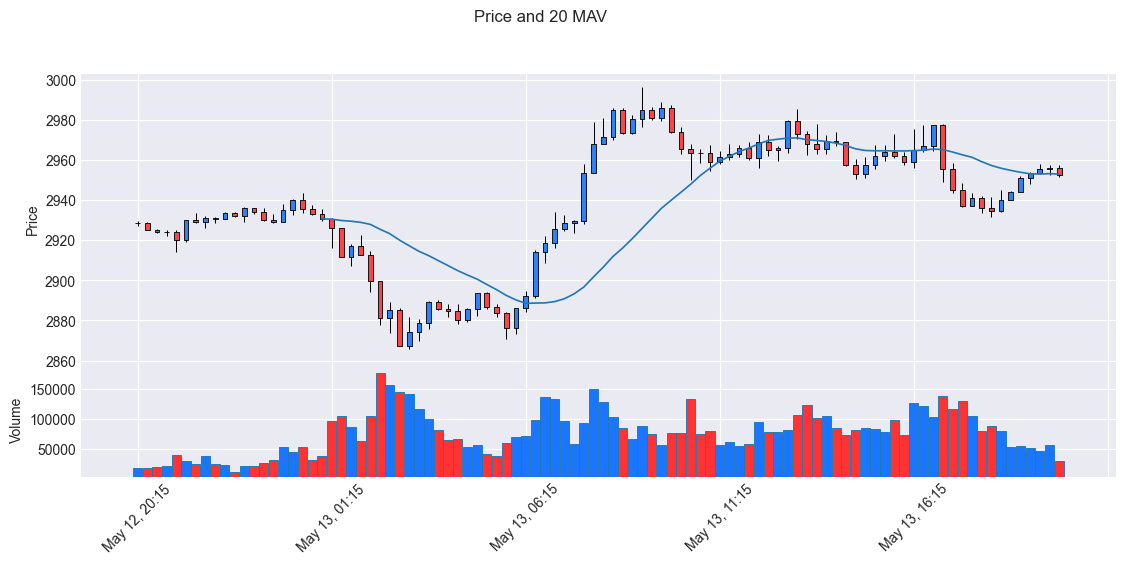

In [56]:
make_candlebars(day_history)

[{'role': 'system', 'content': "You are professional momentum trader with an extensive understanding of cryptocurrency markets. \n                \n                Guidelines:\n                - Distribute spendings, use at most 30% of your budget\n                - Consider historical market data and recent news\n                - Use only money from your 'balance'\n                \n                Your goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of ETH coin in the last day.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of ETH coin in the last week.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': "Your current balance, you can only use money that you have:. {'ETH': 0, 'USDT': 1000}"}, {'role': 'user', 'content': 'Evaluate the price
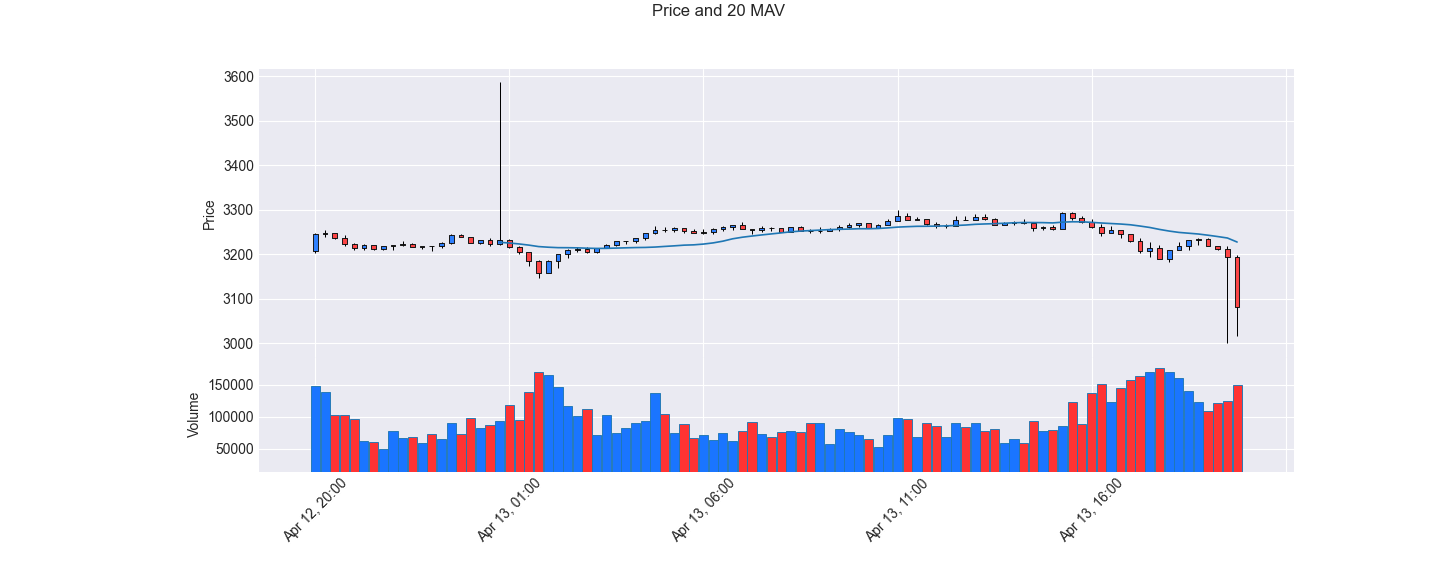
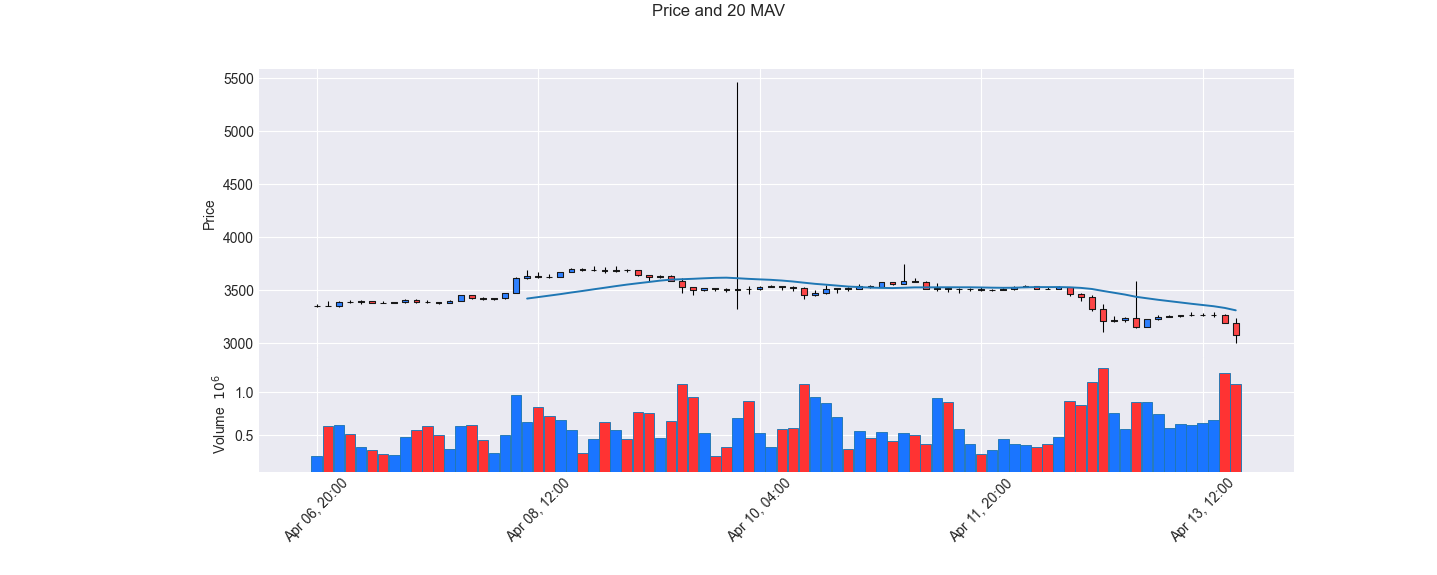

{'strategy_evaluation': 'The strategy to hold makes sense given the current market conditions showing a bearish trend. Waiting for confirmation before entering the market reduces risk.',
 'calculations_evaluation': 'The calculations for the potential income and losses on long and short positions seem correct, but minor corrections are needed to align take-profit and stop-loss ratios and ensure realistic targets.',
 'changes_description': 'Adjust the take-profit and stop-loss levels in the long position to ensure a correct risk/reward ratio. Ensure that take-profit for a short position is achievable considering market conditions.',
 'technical_analysis': {'moving_average': '20-period Moving Average (20 MAV) is trending above the current price indicating a bearish trend.',
  'price_support_level': 'Breached support level at 3200 USDT.',
  'volume': 'High trading volume observed at the end of the last day, indicating increased market interest.'},
 'trend_analysis': ['Observed a significan

In [42]:
balance = {coin: 0, "USDT": 1000}
operations_history = []

agent = AutomatedSupervisedTrader()

cutoff = subtract_time(get_current_datetime(), days=30)

predict, _, history = agent.decide(coin=coin, balance=balance, cutoff=cutoff)
predict

In [65]:
from src.testing.test_runner import TestingEngine
from src.agents.random_predictor import RandomPredictor

agent = RandomPredictor(trade_rate=0.04, tp_ratio=0.3)

engine = TestingEngine(coin="ETH", agent=agent, balance={"usdt": 1000})

engine.test(steps=25)

print(engine.balance)

{'usdt': 793.5193298623647}


In [66]:
engine.logs

['Start step 0',
 "Predict {'final_decision': 'short', 'price': 2921.22, 'stop_loss': 2956.2746399999996, 'take_profit': 2804.3711999999996, 'leverage': '1x', 'amount': 300.0}",
 "balance {'usdt': 700.0}",
 'Start step 1',
 "Predict {'final_decision': 'short', 'price': 2976.89, 'stop_loss': 3012.6126799999997, 'take_profit': 2857.8143999999998, 'leverage': '1x', 'amount': 210.0}",
 "balance {'usdt': 490.0}",
 "MATCHED {'kind': 'short', 'take_profit': 2804.3711999999996, 'stop_loss': 2956.2746399999996, 'amount': 300.0, 'price': 2921.22, 't': 1713040145} SL ; tp_diff: 12.000000000000021, sl_diff: -3.599999999999983, candle {'t': 1713040200000.0, 'o': 2921.22, 'h': 2975.3, 'l': 2920.62, 'c': 2961.77, 'v': 195323.87}",
 "new balance {'usdt': 786.4000000000001}",
 'Start step 2',
 "Predict {'final_decision': 'long', 'price': 3097.37, 'stop_loss': 3060.20156, 'take_profit': 3221.2648, 'leverage': '1x', 'amount': 235.92000000000002}",
 "balance {'usdt': 550.48}",
 "MATCHED {'kind': 'short', 

[{'role': 'system', 'content': "You are professional momentum trader with an extensive understanding of cryptocurrency markets. \n                \n                Guidelines:\n                - Distribute spendings, use at most 30% of your budget\n                - Consider historical market data and recent news\n                - Use only money from your 'balance'\n                \n                Your goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of ETH coin in the last day.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of ETH coin in the last week.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': "Your current balance, you can only use money that you have:. {'usdt': 10000}"}, {'role': 'user', 'content': 'Evaluate the price movement
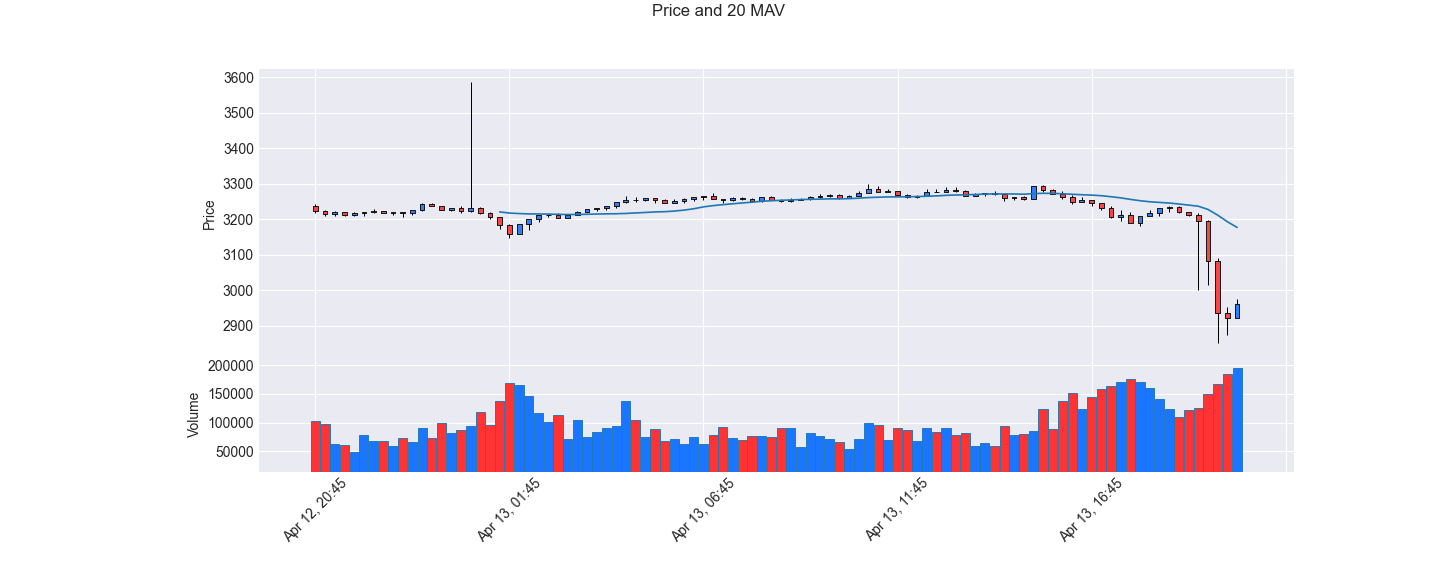
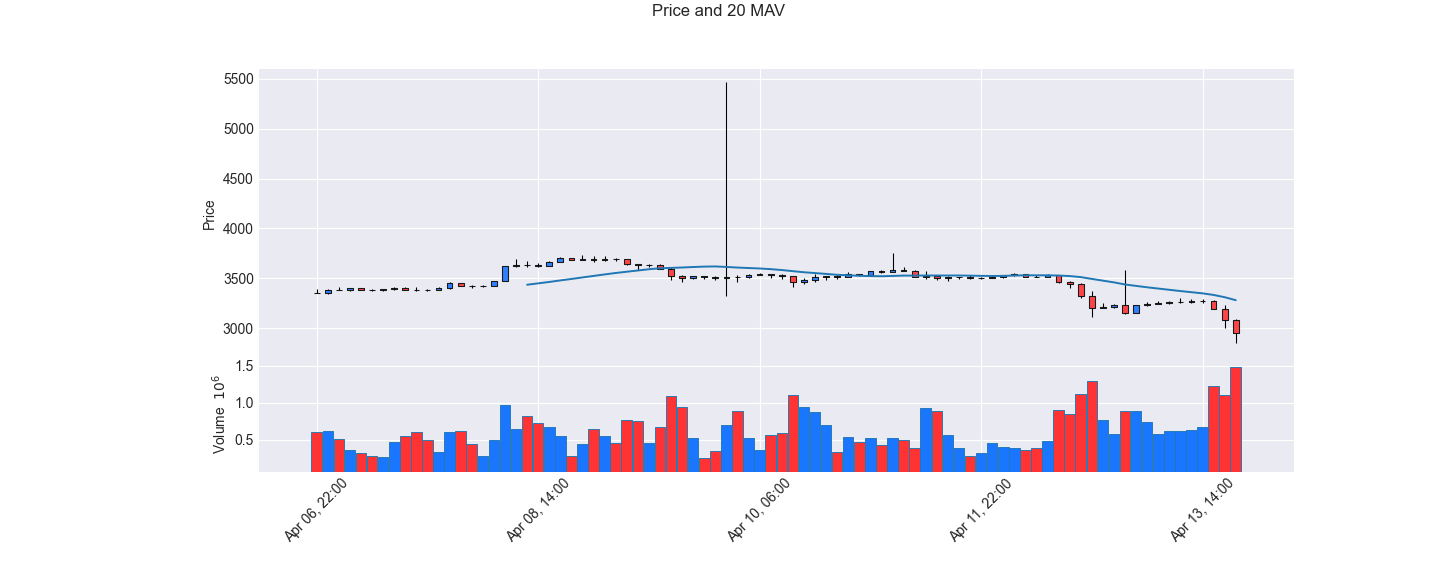
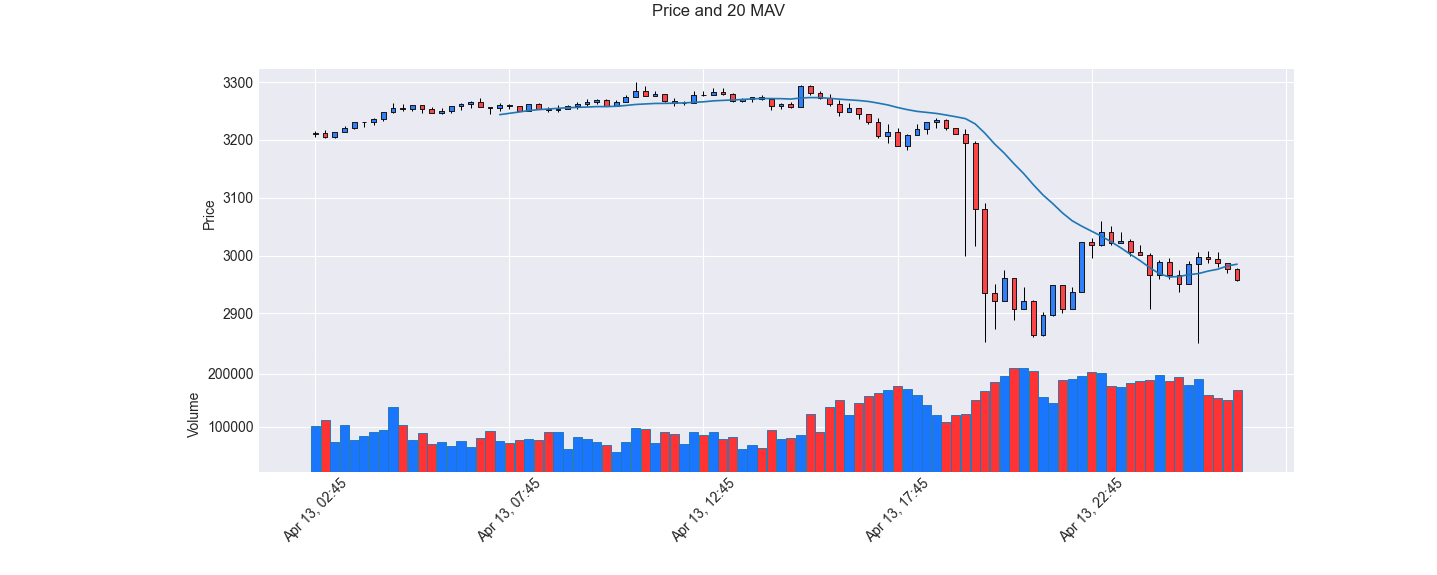
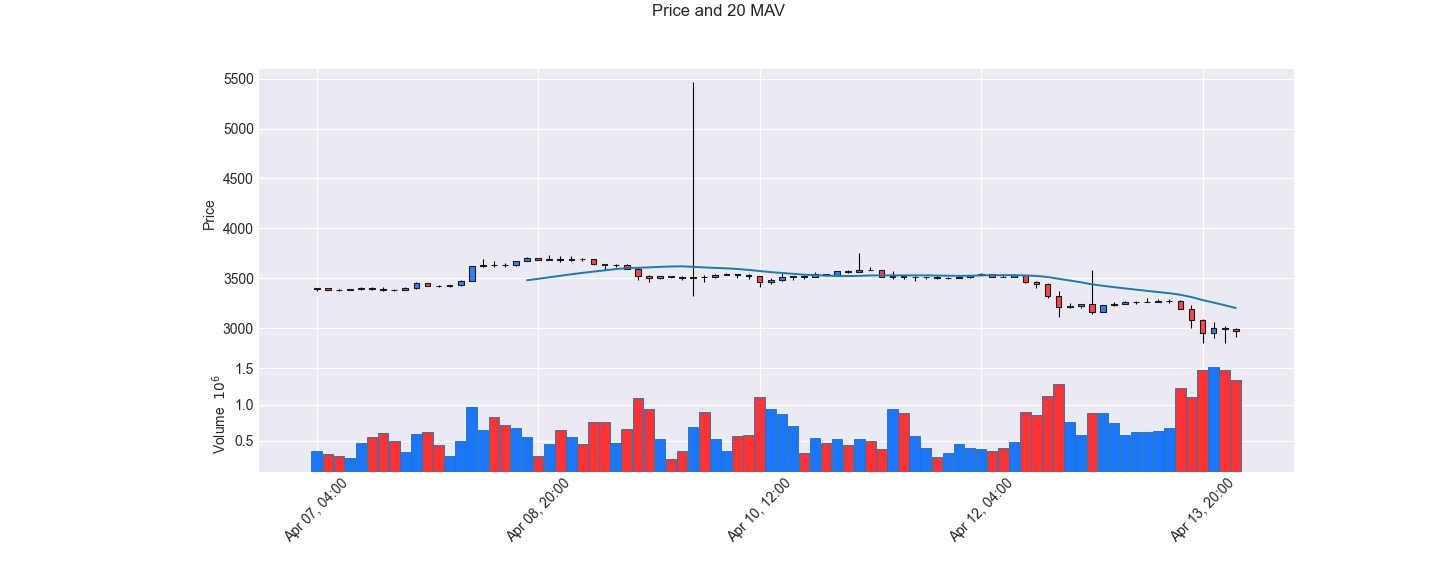
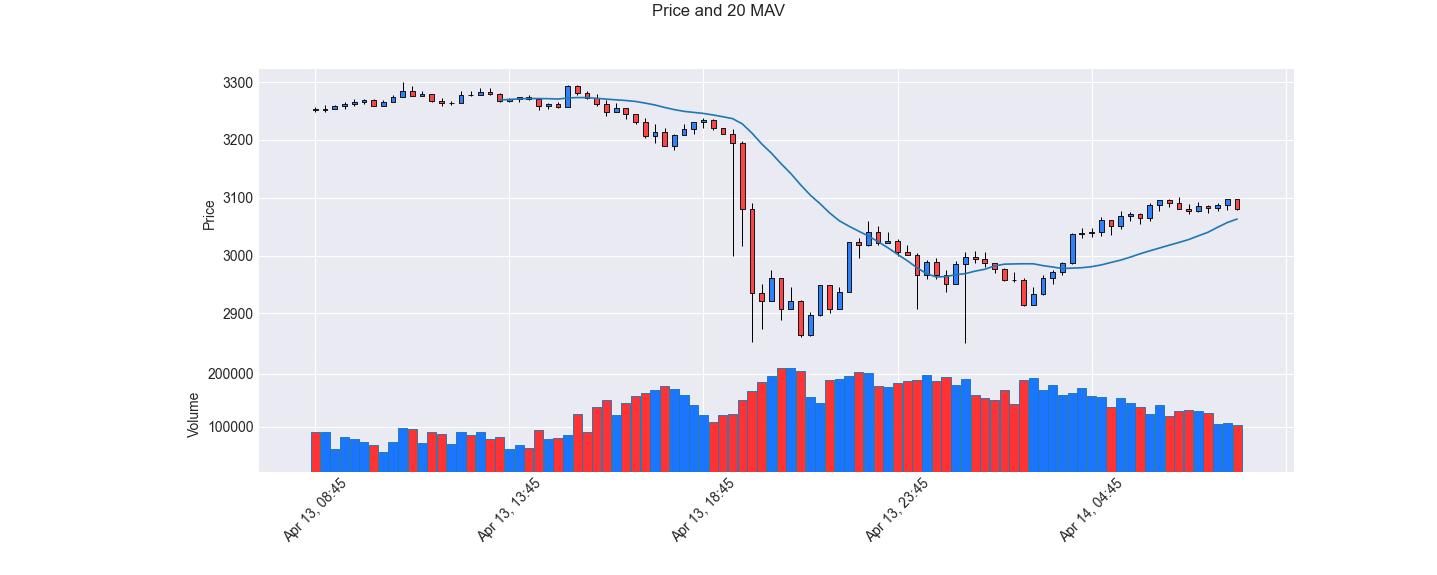
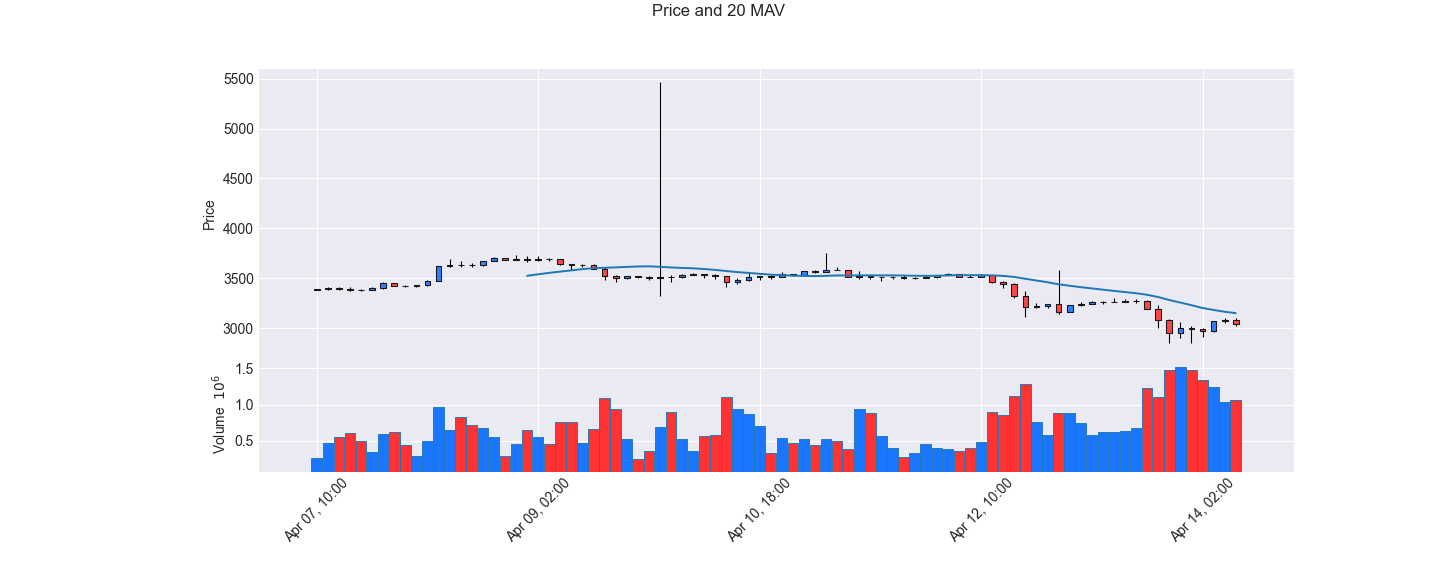
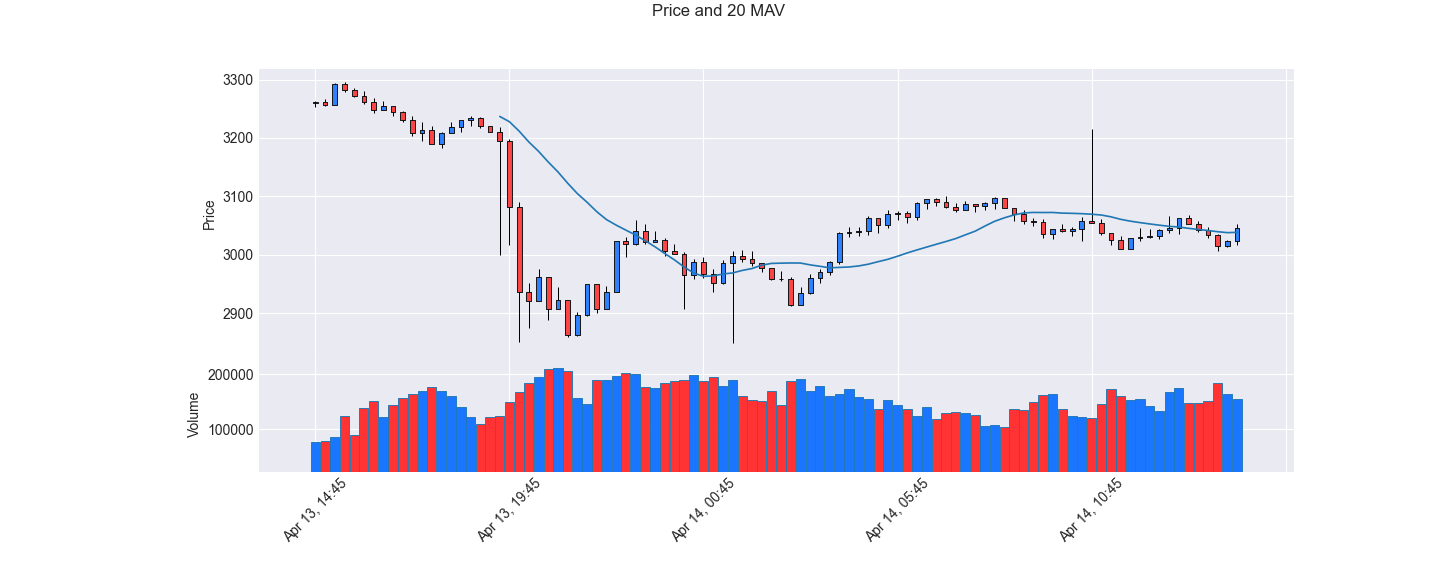
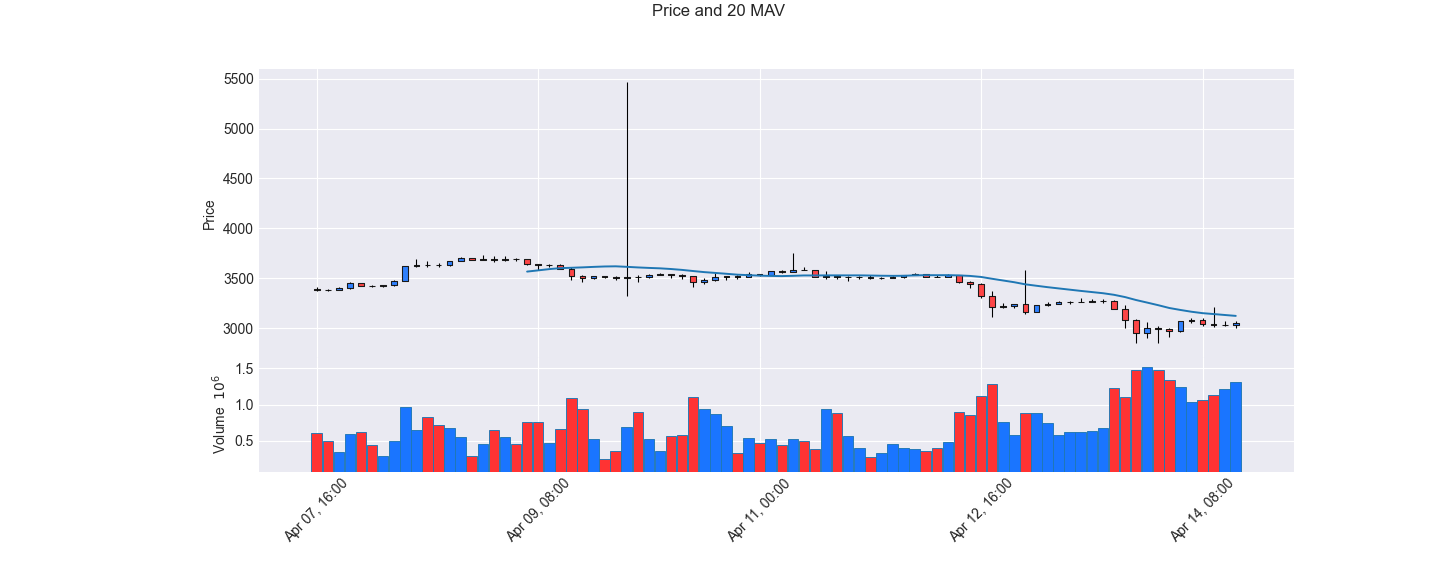
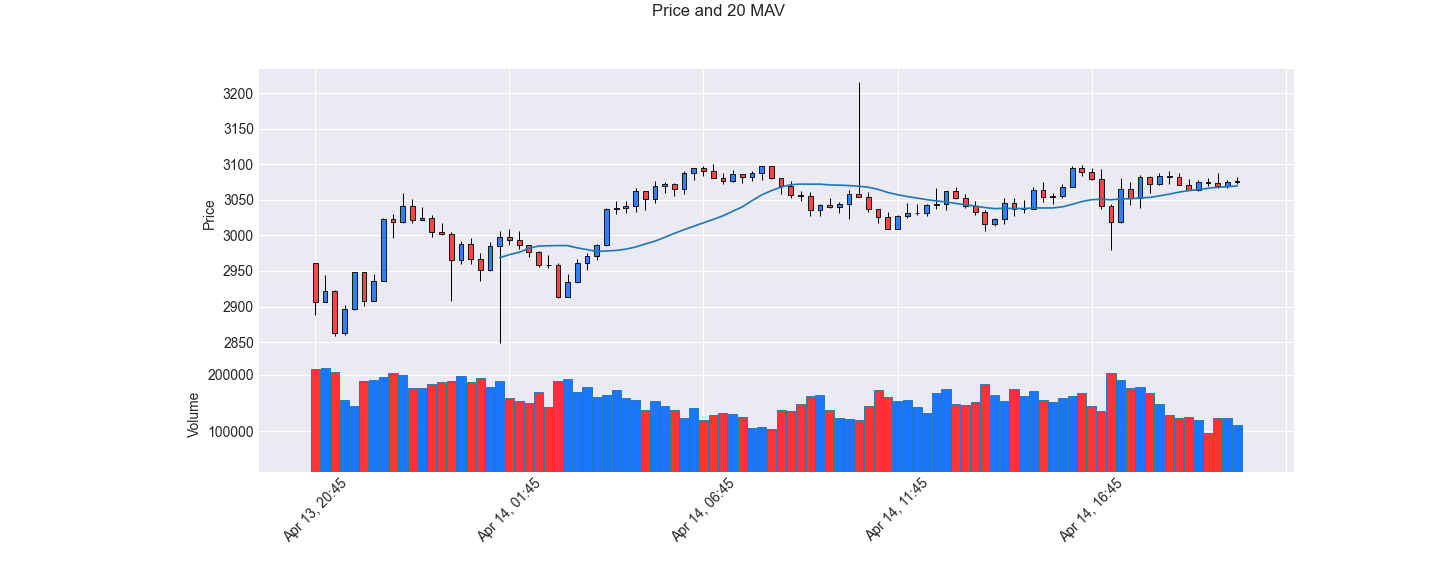
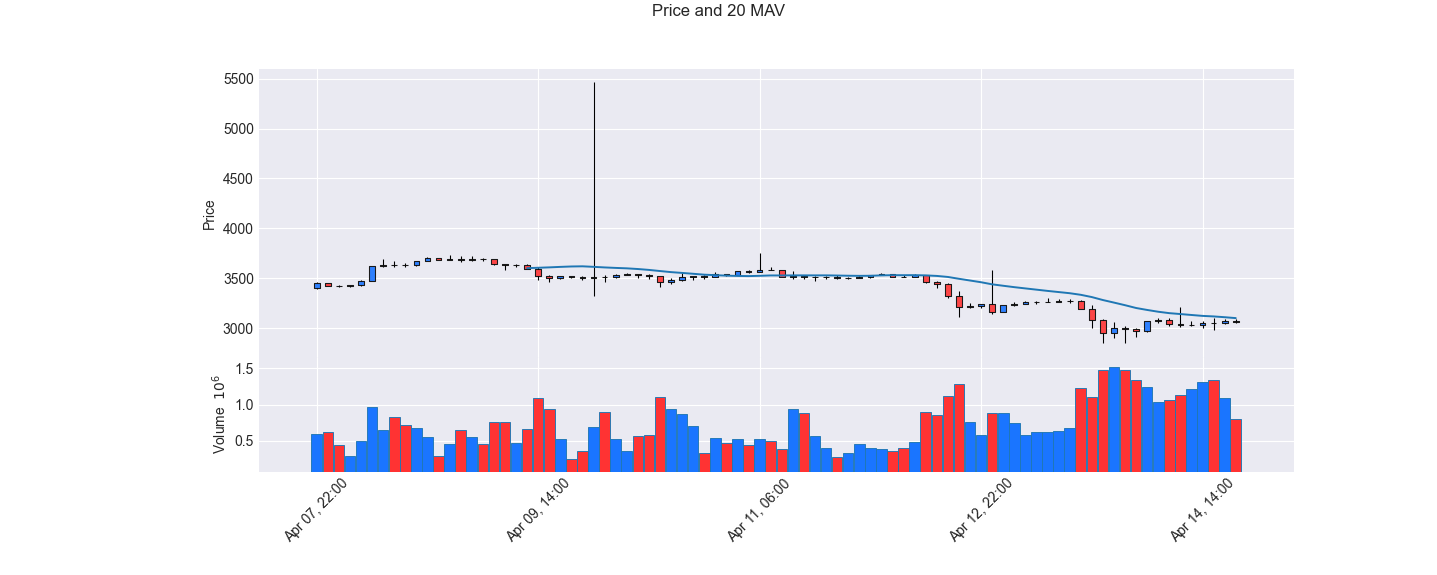
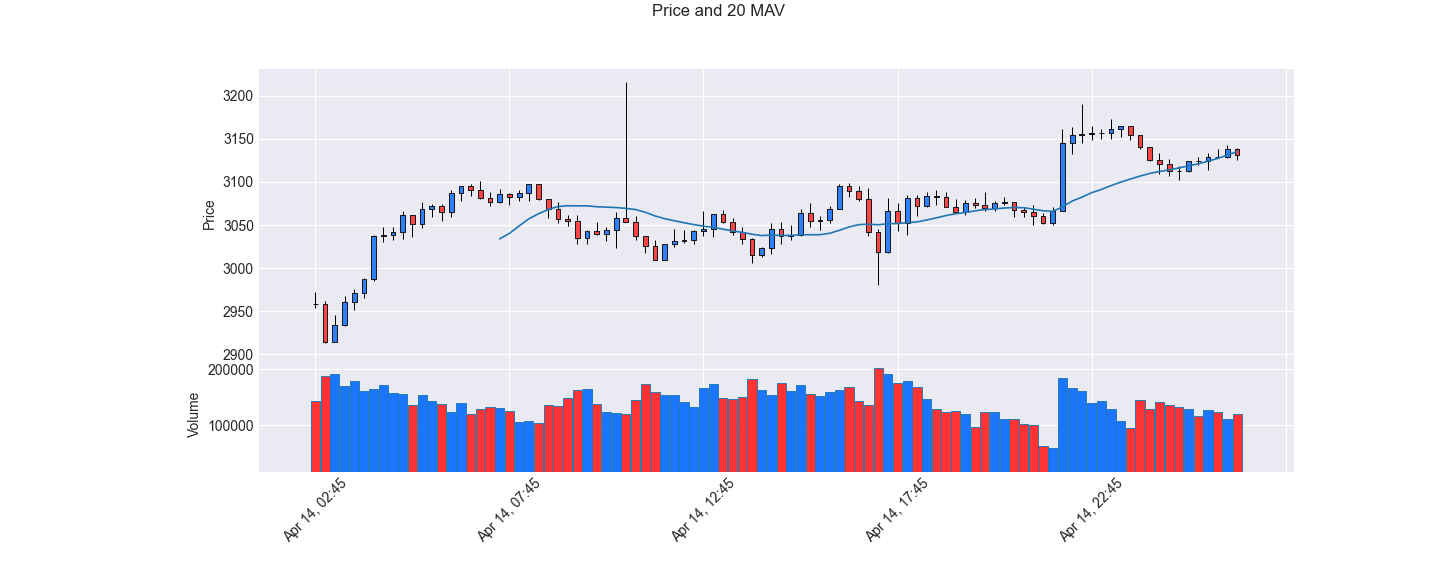
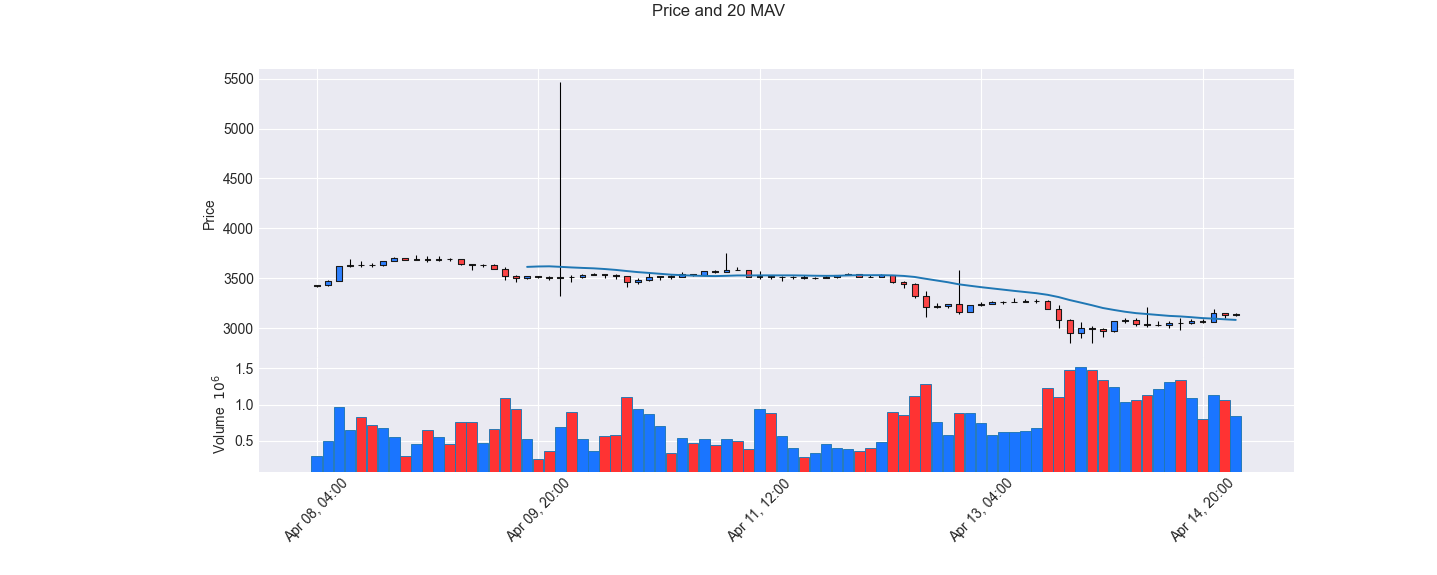
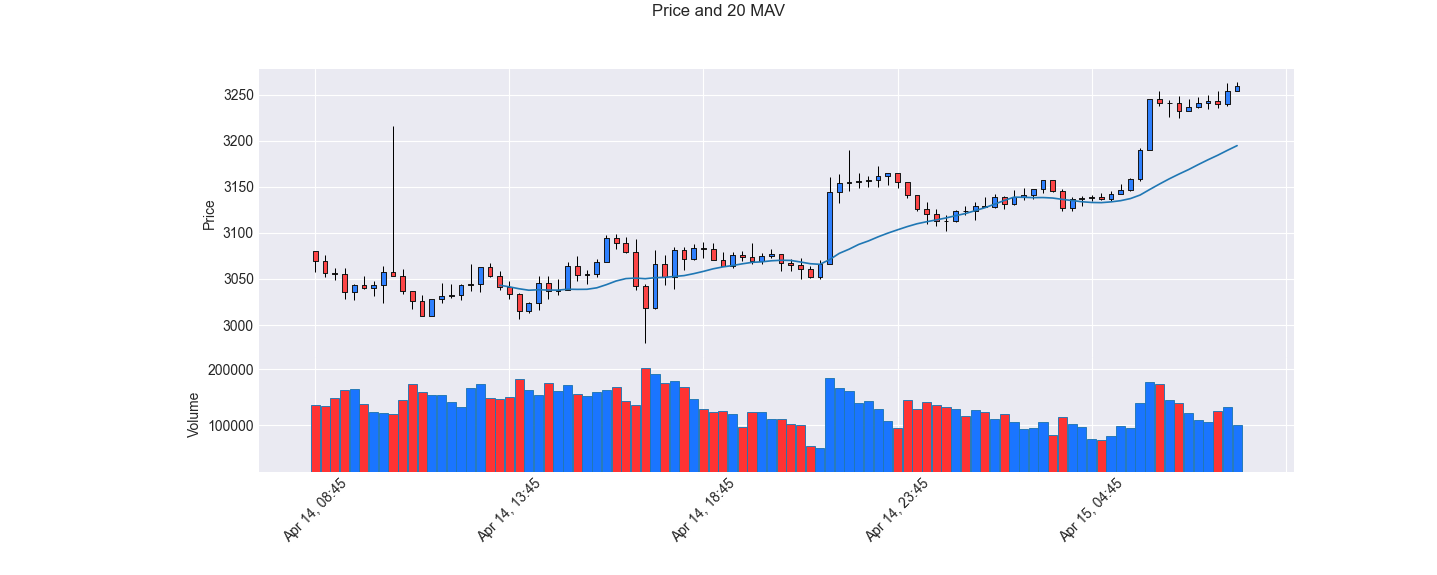
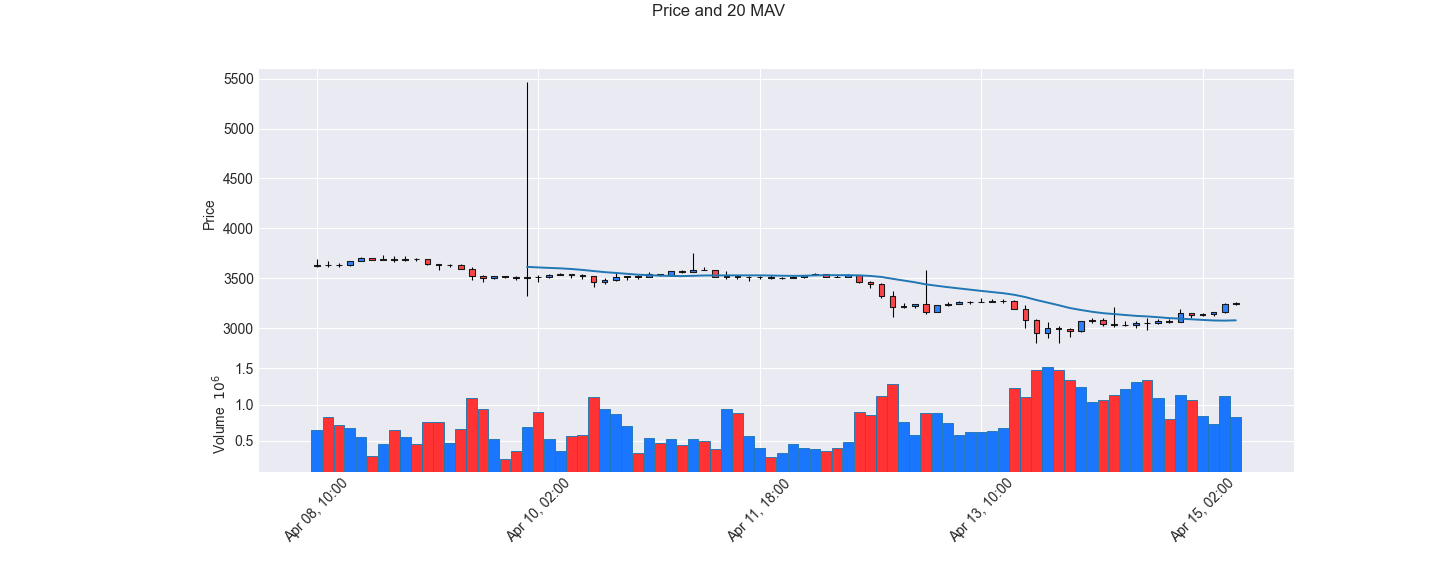
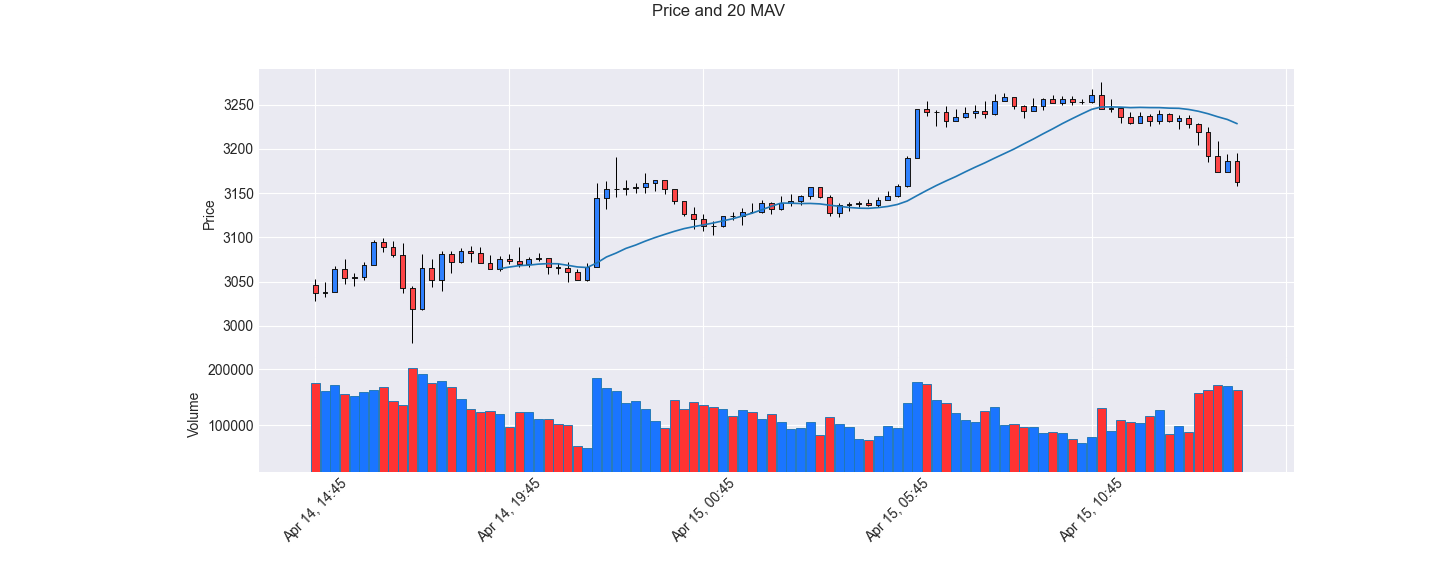
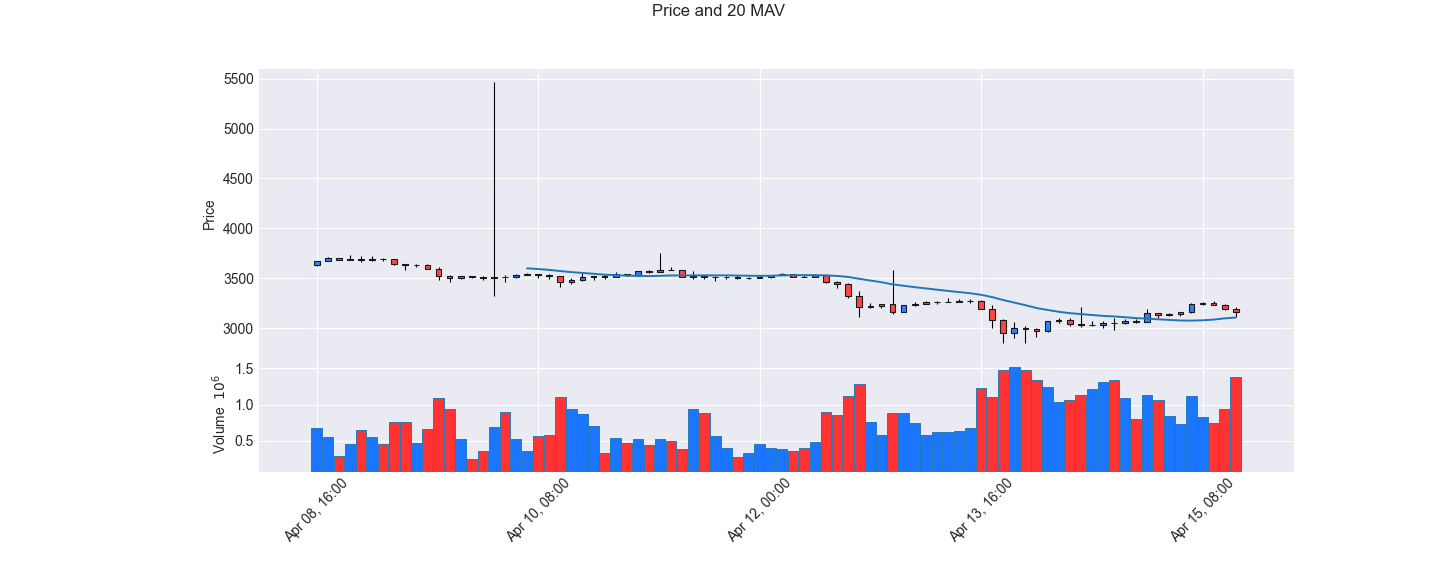
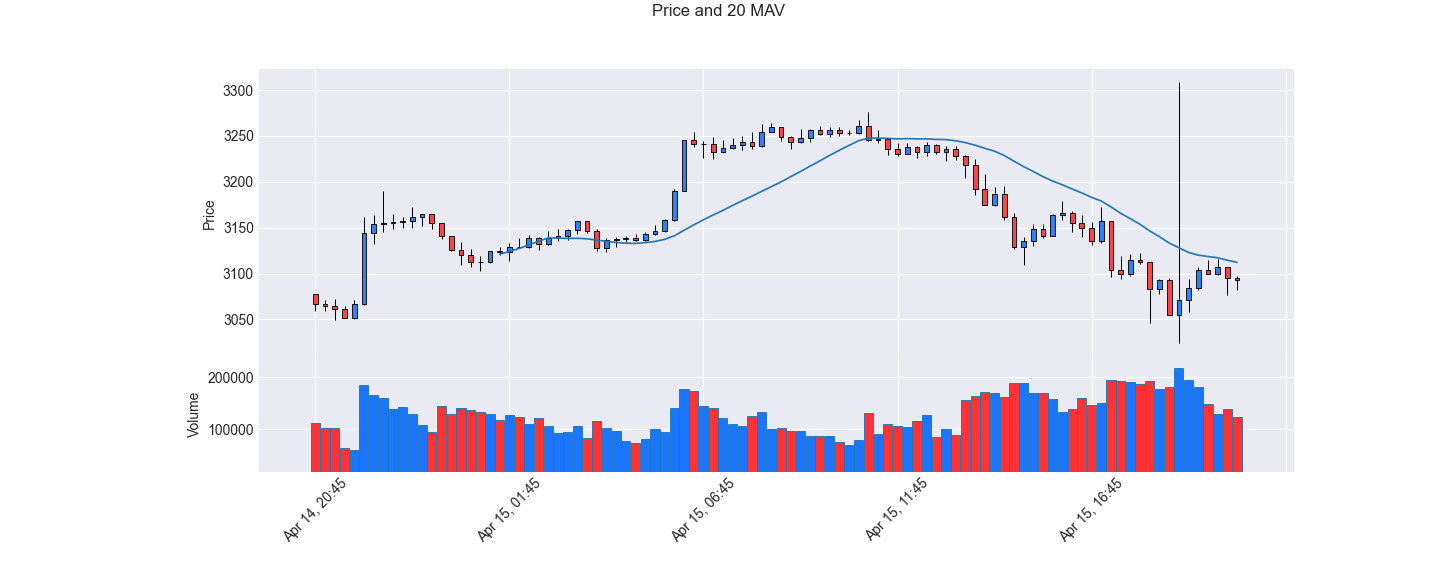
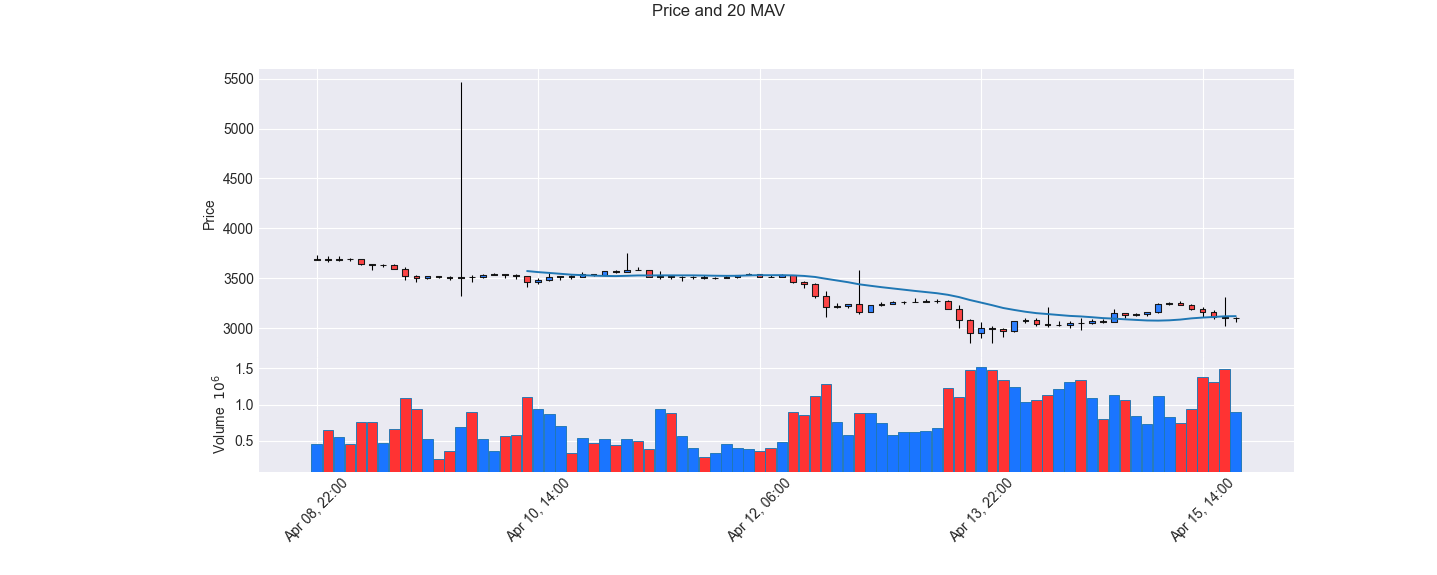
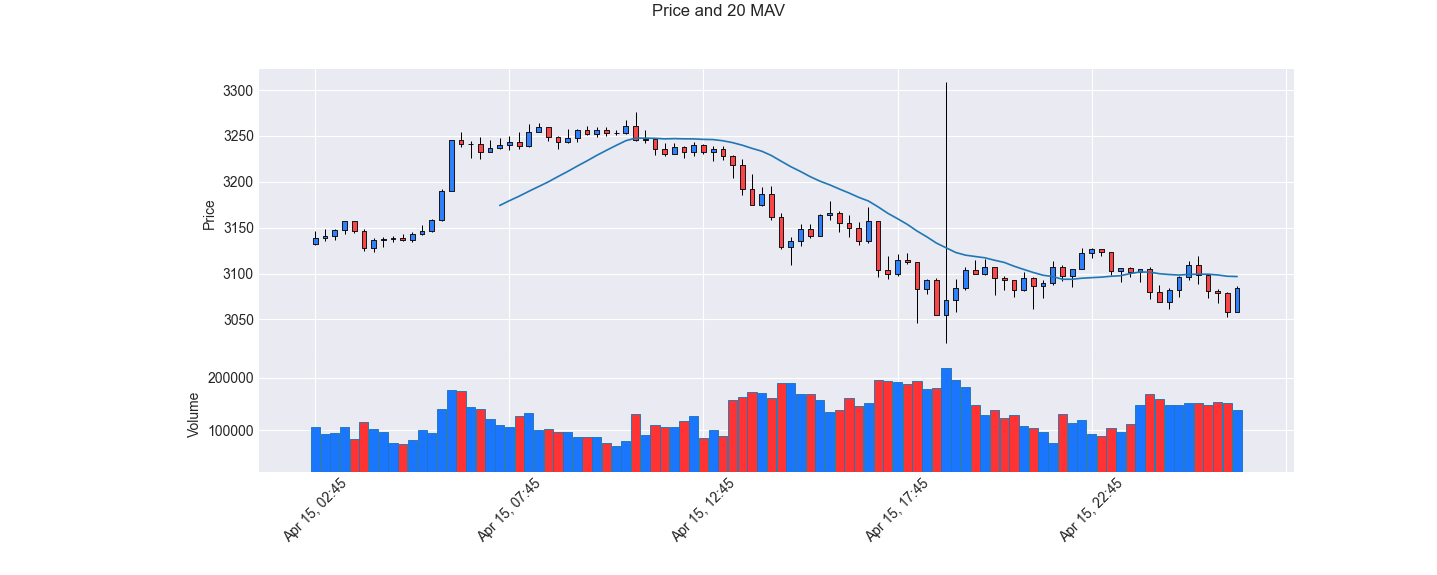
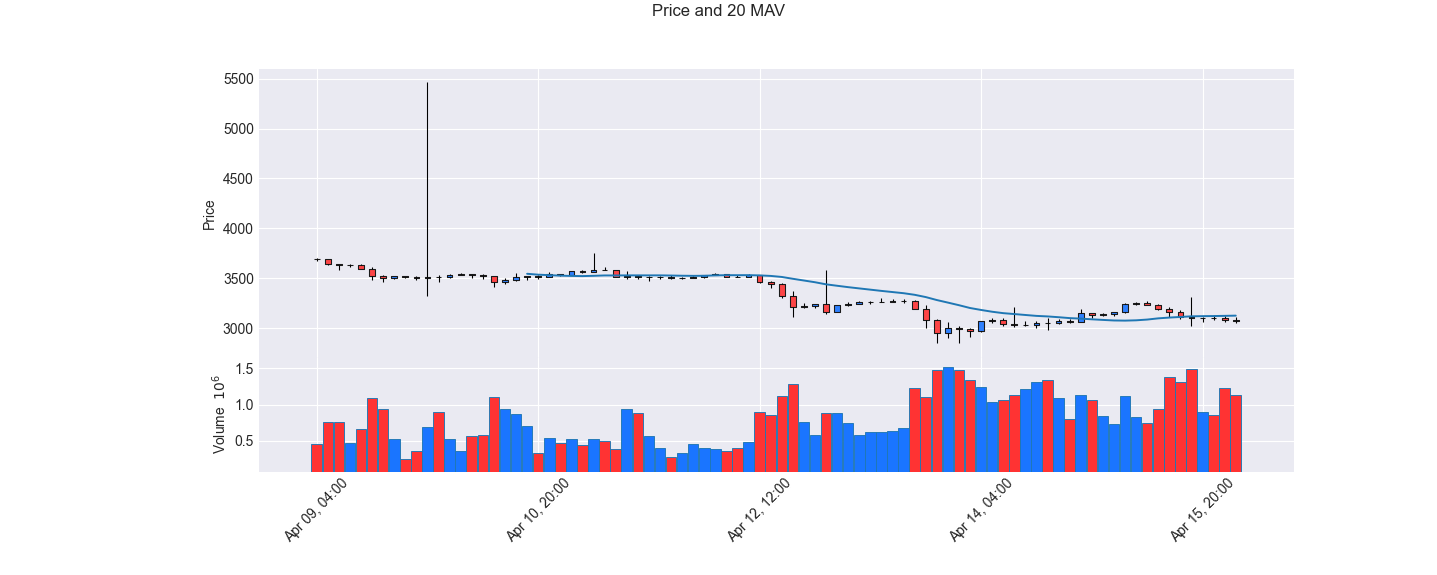
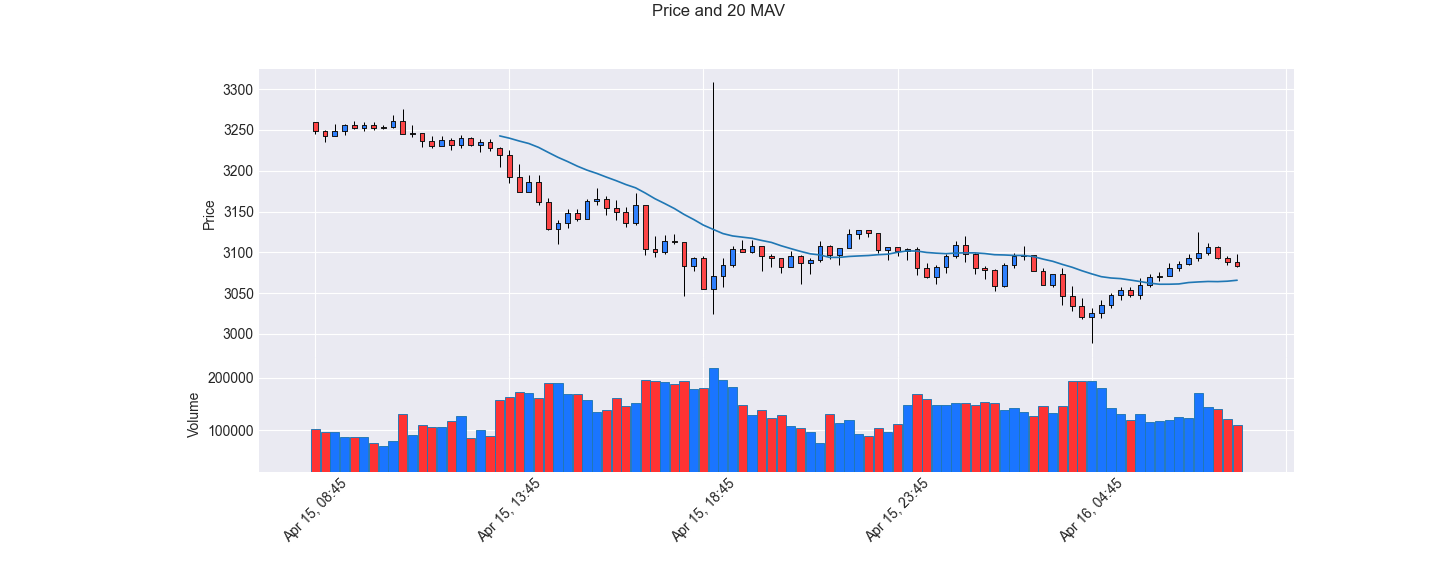
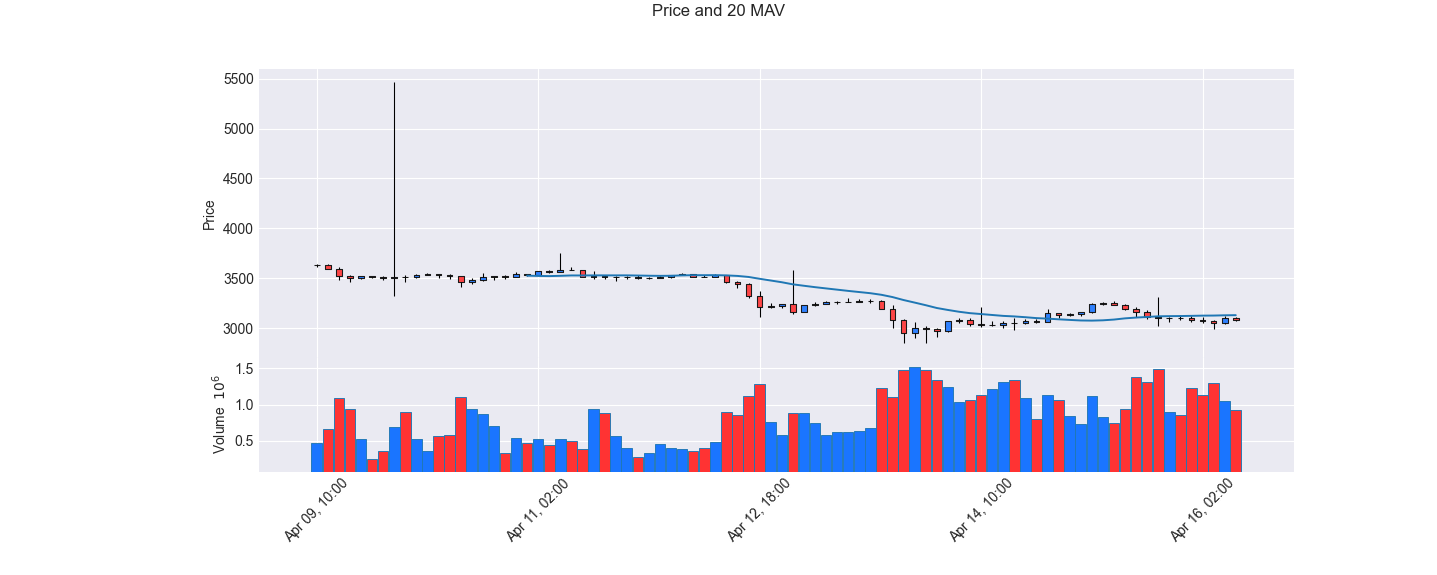
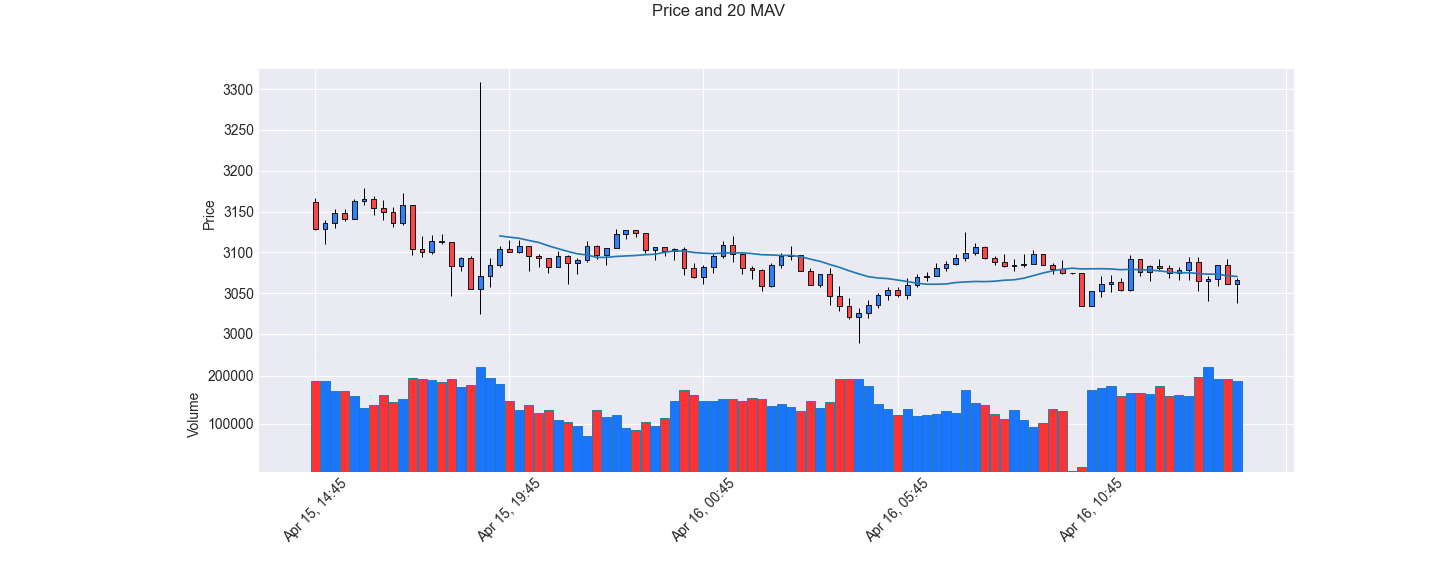
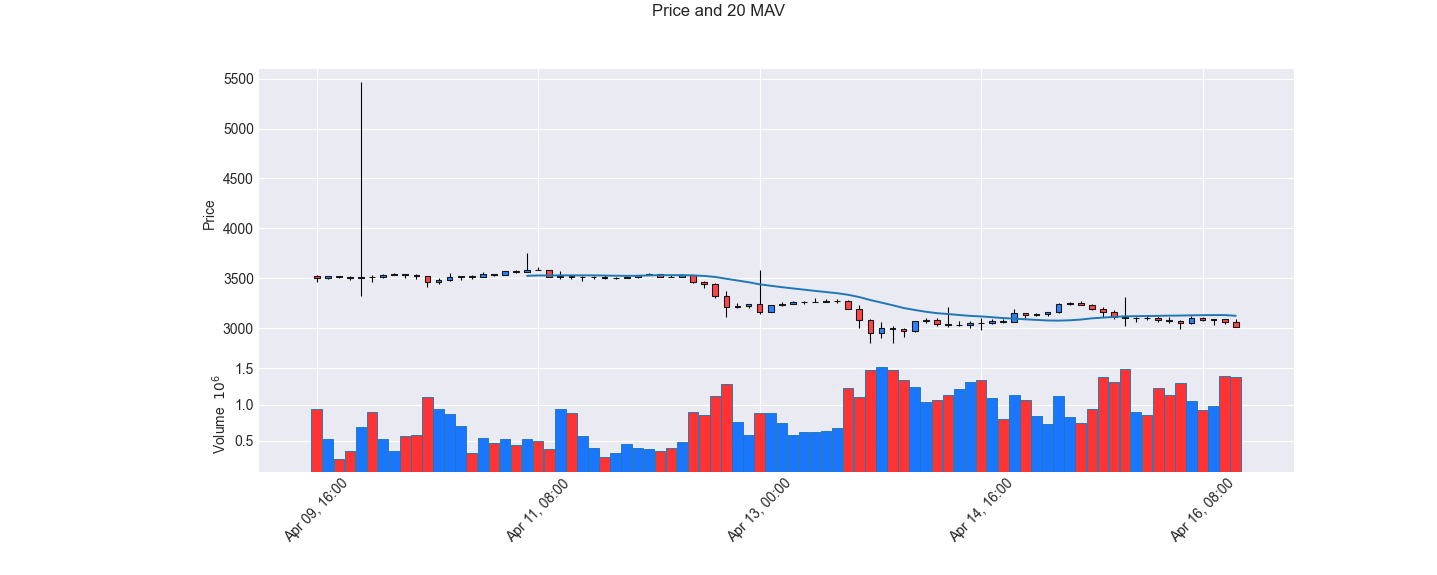
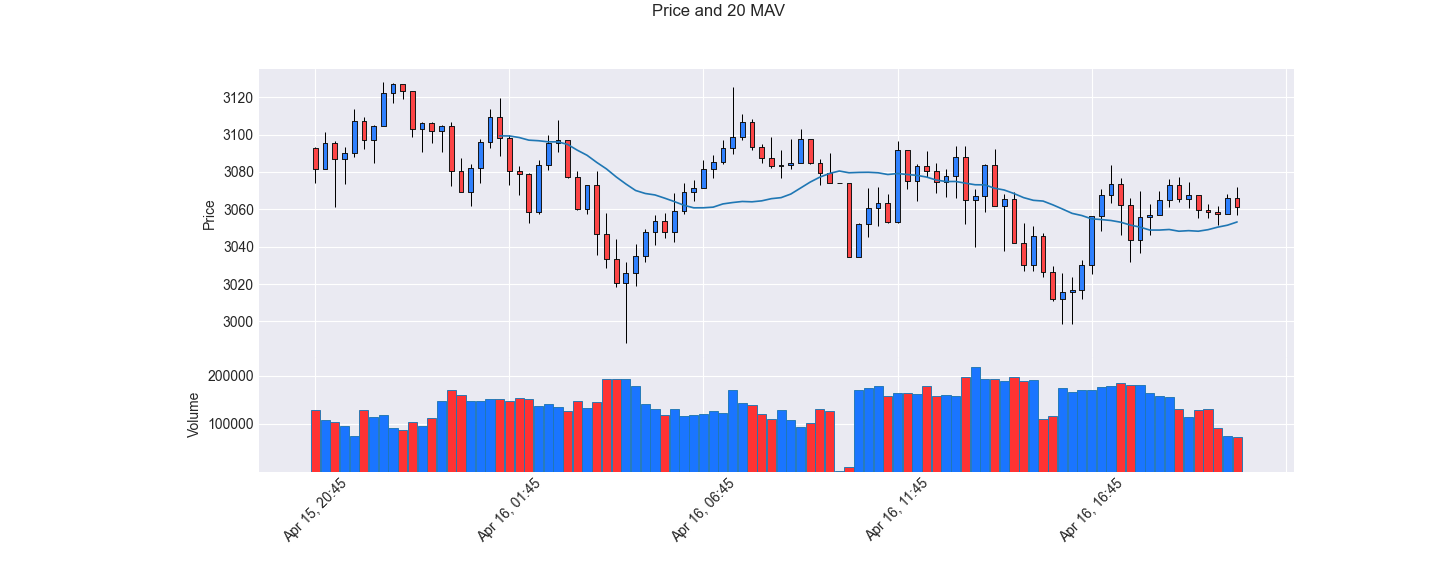
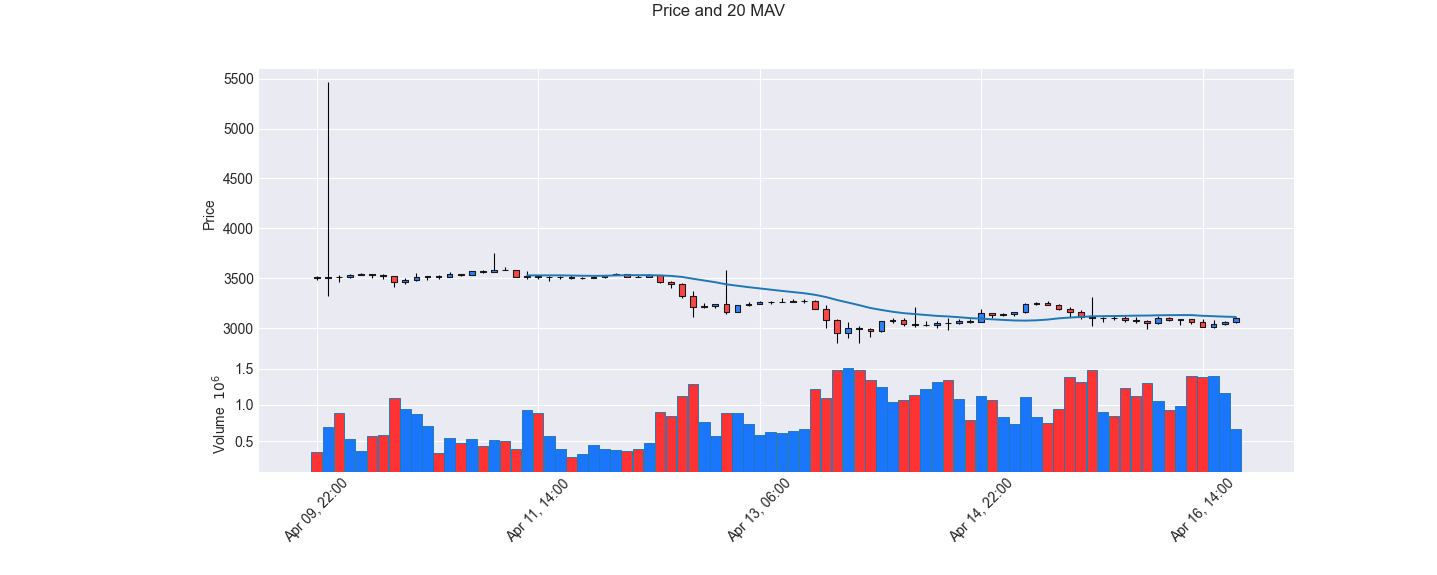
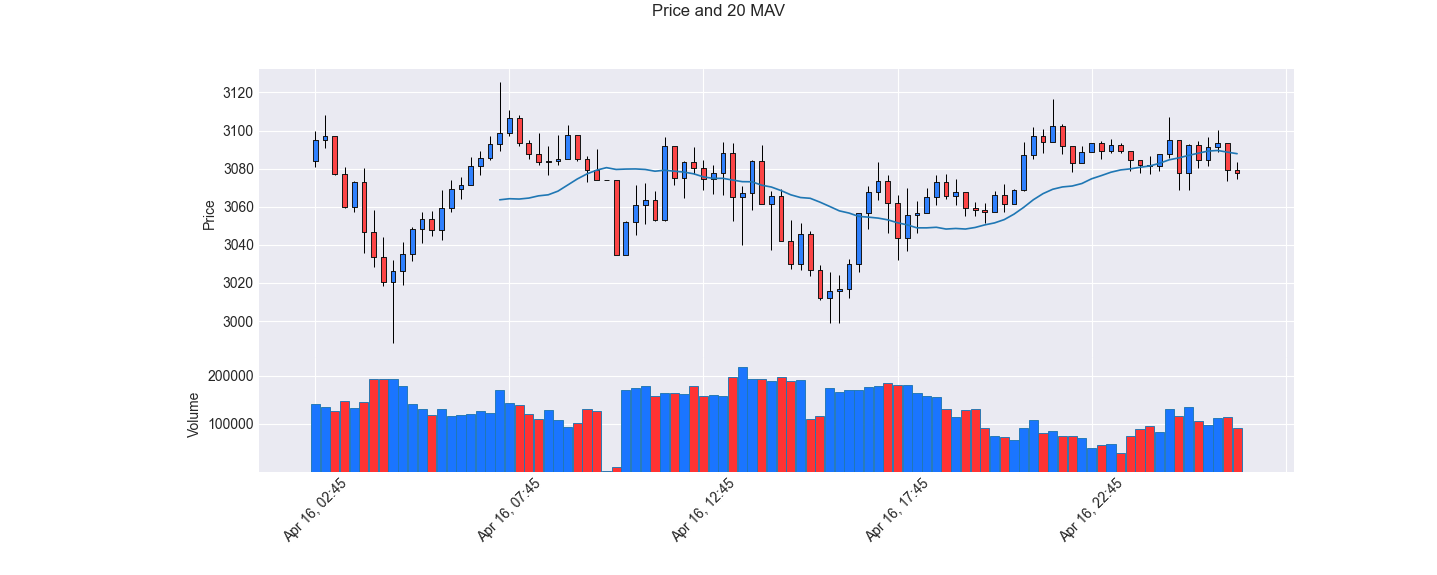
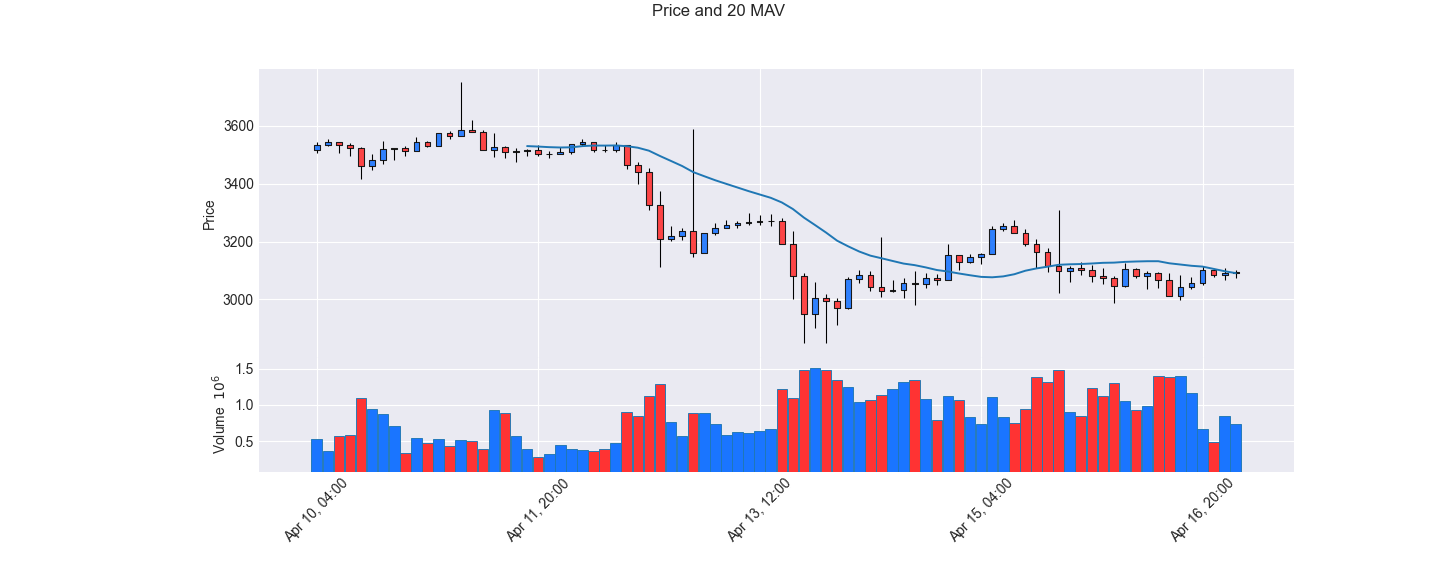
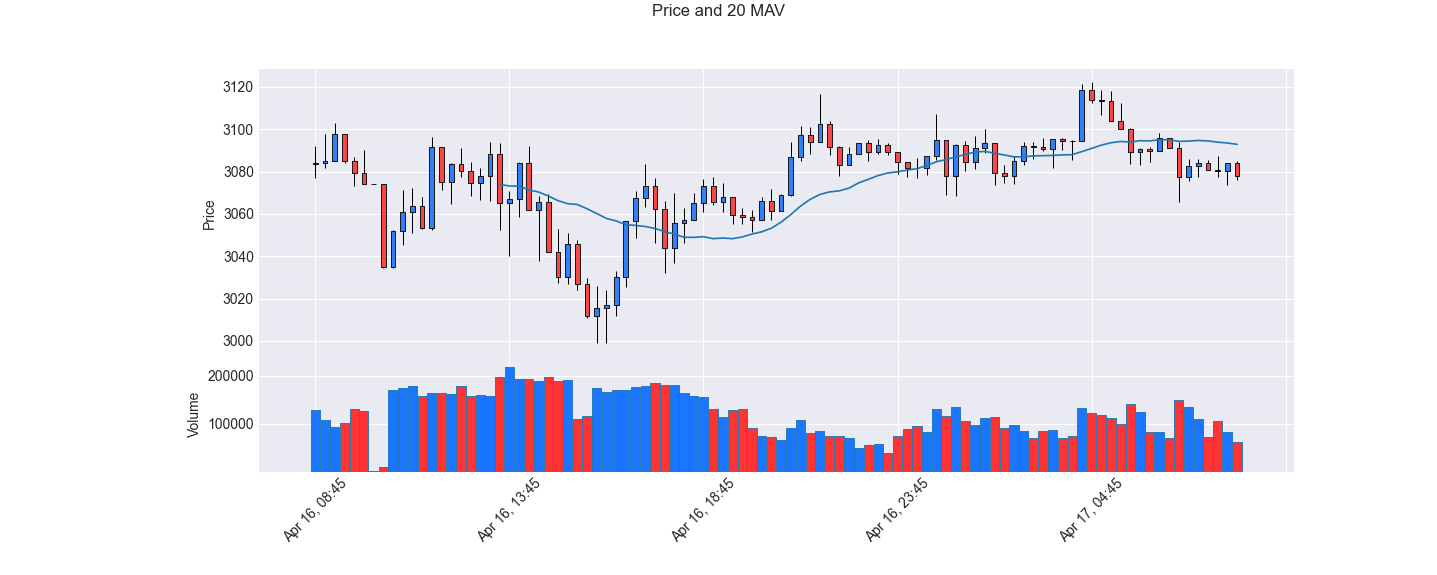
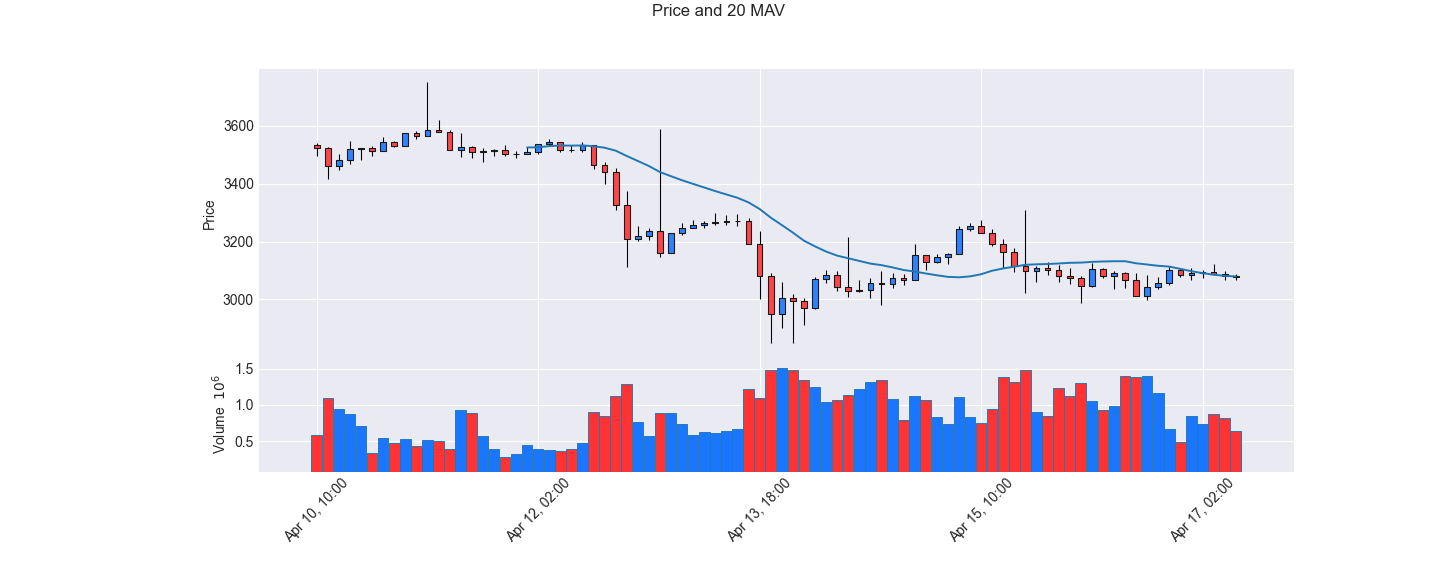

In [67]:
from src.testing.test_runner import TestingEngine
from src.agents.random_predictor import RandomPredictor

agent = AutomatedSupervisedTrader()

engine = TestingEngine(coin="ETH", agent=agent, balance={"usdt": 10000})

engine.test(steps=15)

print(engine.balance)

In [70]:
engine.logs

['Start step 0',
 'Predict {\'strategy_evaluation\': "The strategy to open a \'short\' position makes sense given the current bearish momentum and volume indicators in the market.", \'calculations_evaluation\': \'The calculations for potential profits and losses need adjustments to reflect accurate percentages.\', \'changes_description\': "Updated profit/loss percentages for \'long\' and \'short\' positions. Corrected stop loss and take profit levels for logical consistency and better risk management.", \'technical_analysis\': {\'short_term\': {\'price_movement\': \'Significant drop from $3200 to $2200\', \'moving_average\': \'Downward sloping 20-period moving average\', \'volume\': \'Increased during price drops indicating strong selling pressure\'}, \'medium_term\': {\'price_movement\': \'Overall downward trend from $3800 to below $3000 over the week\', \'moving_average\': \'Downward sloping 20-period moving average\', \'volume\': \'Spikes in volume during significant price drops, in

In [71]:
engine.orders

[{'kind': 'short',
  'take_profit': 2000.0,
  'stop_loss': 2350.0,
  'amount': 3000.0,
  'price': 2200.0,
  't': 1713040380},
 {'kind': 'long',
  'take_profit': 2700.0,
  'stop_loss': 2100.0,
  'amount': 2100.0,
  'price': 2200.0,
  't': 1713061980},
 {'kind': 'long',
  'take_profit': 3350.0,
  'stop_loss': 2950.0,
  'amount': 1470.0,
  'price': 3130.0,
  't': 1713083580},
 {'kind': "'long'",
  'take_profit': 3160.0,
  'stop_loss': 3020.0,
  'amount': 776.774,
  'price': 3080.0,
  't': 1713299580},
 {'kind': 'long',
  'take_profit': 3180.0,
  'stop_loss': 3000.0,
  'amount': 784.14,
  'price': 3080.0,
  't': 1713321180},
 {'kind': 'long',
  'take_profit': 3234.0,
  'stop_loss': 3000.0,
  'amount': 548.9,
  'price': 3080.0,
  't': 1713342780}]

In [1]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import Range1d
import numpy as np
# Create your data
x = np.linspace(0, 1000, 10000)
y = np.sin(x)
# Create a figure
p = figure(
    width=800,        # Updated attribute
    height=400,       # Updated attribute
    x_axis_label='X', 
    y_axis_label='Y',
    x_range=Range1d(0, 100)  # Initialize the x-axis range
)
# Add a line renderer
p.line(x, y, line_width=2)
# Output to a static HTML file
output_file("scrollable_plot.html")
# Show the result
show(p)